In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF
from thor_magni_tools.io import load_json_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
DIR_PATH = "/home/jakubassa/imitation-learning-socially-integrated-navigation/THOR_MAGNI/CSVs_Scenarios"
VISUALS_PATH = "/home/jakubassa/imitation-learning-socially-integrated-navigation/THOR_MAGNI/maps"

FILE_NAME = "THOR-Magni_120522_SC1B_R1.csv"

In [62]:
experiment_info = FILE_NAME.split("_")
date, scenario = experiment_info[1][:4], experiment_info[2]
month = "May" if date[2:] == "05" else "September"

scenario_map = scenario
if scenario in ["SC3A", "SC3B"]:
    scenario_map = "SC3"

In [63]:
raw_df, header_dict = load_csv_metadata_magni(
    os.path.join(DIR_PATH, f"Scenario_{scenario_map[2]}", FILE_NAME)
)

In [64]:
new_header_dict = preprocessing_header_magni(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

### Filtering best markers

In [65]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [66]:
best_markers_traj[["x", "y"]] /= 1000 # to m

### Helper pix <-> m 

In [67]:
class PixWorldConverter:
    """Pixel to world converter"""

    def __init__(self, info: dict) -> None:
        self.resolution = info["resolution_pm"]  # 1pix -> m
        self.offset = np.array(info["offset"])

    def convert2pixels(self, world_locations: np.array) -> np.array:
        if world_locations.ndim == 2:
            return (world_locations / self.resolution) - self.offset

        new_world_locations = [
            self.convert2pixels(world_location) for world_location in world_locations
        ]
        return np.stack(new_world_locations)

    def convert2world(self, pix_locations: np.array) -> np.array:
        return (pix_locations + self.offset) * self.resolution

In [68]:
vis_path = (
    os.path.join(VISUALS_PATH, f"{date}_map.png")
    if scenario_map in ["SC4A", "SC4B", "SC5"]
    else os.path.join(VISUALS_PATH, f"{date}_{scenario_map}_map.png")
)

In [69]:
offsets = load_json_file(os.path.join(VISUALS_PATH, "offsets.json"))
info = {"resolution_pm" : 0.01, "offset": offsets[month]} 
pix2world_converter = PixWorldConverter(info)

In [70]:
img = Image.open(vis_path)
targ_img = np.array(img)
map_layout  = np.flipud(targ_img[:,:,:3])

# Plot trajectories

In [71]:
best_markers_traj = best_markers_traj.copy()
best_markers_traj.loc[:, ["x_px", "y_px"]] = pix2world_converter.convert2pixels(
    best_markers_traj[["x", "y"]].values
)

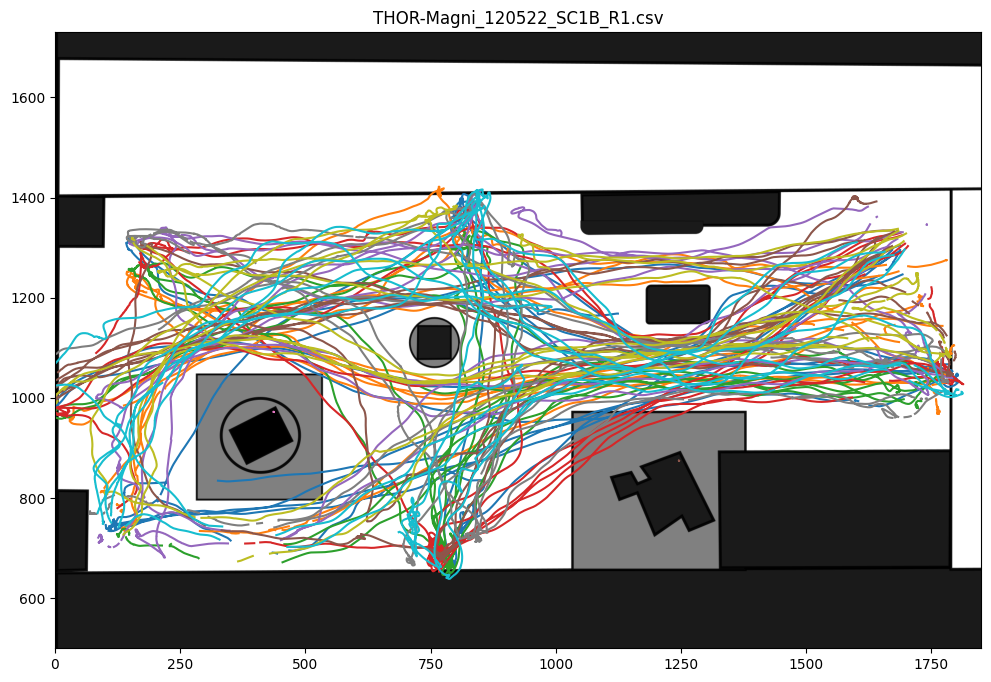

In [72]:
plt.figure(figsize=(16, 8))
plt.title(FILE_NAME);
plt.imshow(map_layout);
for agent_id in best_markers_traj.ag_id.unique():
    traj_agent = best_markers_traj[best_markers_traj["ag_id"] == agent_id]
    label = agent_id + f" ({roles[agent_id]})" if roles else ""
    plt.plot(traj_agent["x_px"], traj_agent["y_px"], label=label)
plt.xlim([0, 1850]);
plt.ylim([500, 1730]);